In [37]:
# Supervised Machine learning prediction

# For this personnal project, we will try to predict a StarCraft II players' ranking (e.g., his competitive tier which 
# includes Bronze, Silver, Gold, Platinum, Diamond, Master and GrandMaster) from a dataset of a published paper in 2013. 
# This dataset includes various telemetrics variables from the players that goes from the total hours played on it to the 
# number of attacks they launched from the minimap, for exemple. 

# Following the [recommendation](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) found on the sklearn documentation on supervised machine learning, 
# it seems that our model, considering our data, should involve a ensemble method (e.g., decision tree / random forest) 
# to predict ones' rank - but, we will also try some support vector machine (SVM) for the sake of it.

# At each step of the analysis, from cleaning the data to exploratory data analysis to modeling, we will describe what has 
# been done and why it has been done. This structure will allow me to teach myself a little more about python, and also new 
# modeling solution that I've never explored yet.

# Happy machine learning!

# Data found here https://www.kaggle.com/danofer/skillcraft / http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset
# PLOSOne publication : https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0075129

In [2]:
# Importing relevant modules / packages for the upcoming analysis
%matplotlib inline
%autosave 60

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn is an extremely useful module for data visualization with tidy principles. 
                      # Reminds me a lot of ggplot2 in R, which I loved.

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score,classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.tree import export_graphviz
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import graphviz # visualization of the decision trees
import scipy.stats as stats # statistical module to add the pearson correlations and p values to the plots
from statsmodels.distributions.empirical_distribution import ECDF

import warnings
warnings.filterwarnings("ignore")

Autosaving every 60 seconds


C:\Users\mabouchard\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\mabouchard\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\mabouchard\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classe

In [3]:
# Data loading
sns.set(color_codes=True) # setting the initial seaborn preset for subsequent plotting
scp = pd.read_csv("Skillcraft.csv")
scp = scp.drop(columns=['GameID']) # Dropping the IDs - not useful for us.
scp.head() # printing the first 5 rows of the dataset

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


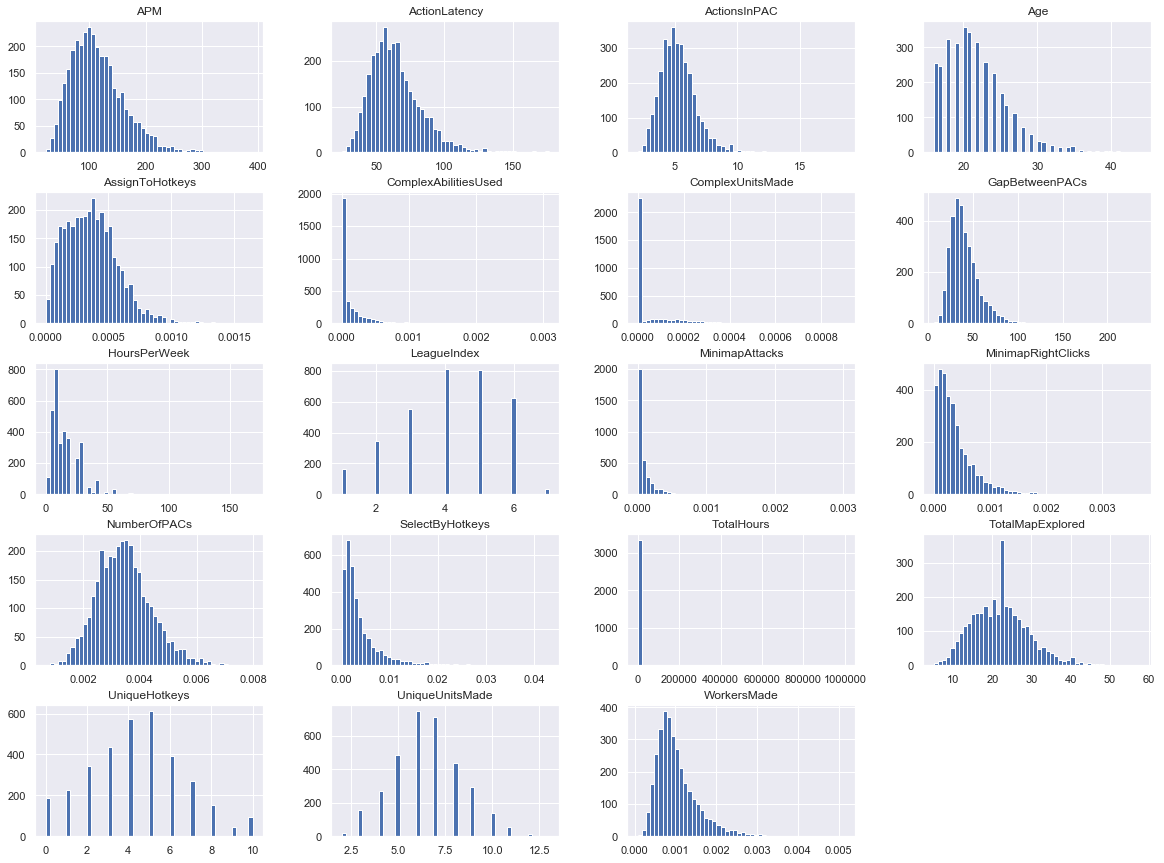

In [5]:
# First glimpse at the data variables with distribution plots / boxplots
# Warning - this for loop will generate a high quantity of plots to visualize
scp.hist(bins=50, figsize=(20,15))
plt.show()

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000
mean,4.116496,21.658037,15.779651,625.246237,114.324882,0.004002,0.000364,4.315172,0.000093,0.000379,0.003430,40.748066,64.276090,5.265631,22.090006,0.001030,6.537929,0.000060,0.000141
std,1.448079,4.210851,11.354074,488.209132,47.904278,0.004699,0.000210,2.331656,0.000157,0.000359,0.000965,17.070693,19.038100,1.502769,7.432849,0.000520,1.858574,0.000112,0.000264
min,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,3.000000,19.000000,8.000000,300.000000,79.124400,0.001242,0.000202,3.000000,0.000000,0.000138,0.002740,29.351850,50.990325,4.257675,17.000000,0.000682,5.000000,0.000000,0.000000
50%,4.000000,21.000000,12.000000,500.000000,106.997100,0.002432,0.000348,4.000000,0.000038,0.000277,0.003372,37.082150,61.322750,5.085650,22.000000,0.000903,6.000000,0.000000,0.000020
75%,5.000000,24.000000,20.000000,800.000000,139.909800,0.004920,0.000493,6.000000,0.000112,0.000507,0.003998,48.551600,74.092950,6.026675,27.000000,0.001257,8.000000,0.000087,0.000180
max,7.000000,44.000000,98.000000,4000.000000,389.831400,0.043088,0.001648,10.000000,0.003019,0.003688,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


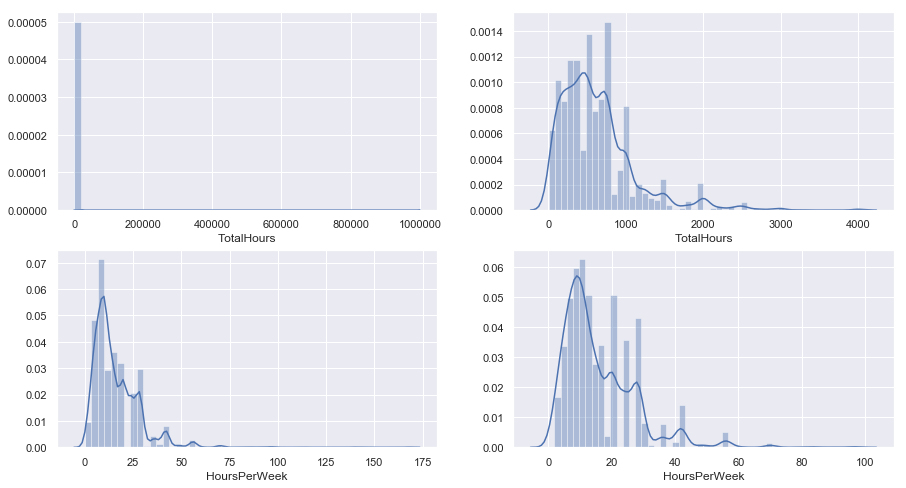

In [4]:
# Removing outliers with IQR / http://colingorrie.github.io/outlier-detection.html
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [2.5, 97.5])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

outliers_totalhours = outliers_iqr(scp['TotalHours']) # Dropping low / high IQR datapoints for TotalHours variable
scp_clean = scp.drop(scp.index[outliers_totalhours])

outliers_hoursperweek = outliers_iqr(scp_clean['HoursPerWeek']) # Dropping low / high IQR datapoints for HoursPerWeek variable
scp_clean = scp_clean.drop(scp_clean.index[outliers_hoursperweek])

dims = (15, 8)
f, axes = plt.subplots(2, 2, figsize=dims)
sns.distplot(scp['TotalHours'], ax=axes[0,0]) # Before cleaning (w/ extreme outlier)
sns.distplot(scp_clean['TotalHours'], ax=axes[0,1]) # After cleaning (without extreme outlier)
sns.distplot(scp['HoursPerWeek'], ax=axes[1,0]) # Before cleaning (w/ extreme outlier)
sns.distplot(scp_clean['HoursPerWeek'], ax=axes[1,1]) # After cleaning (without extreme outlier)

scp_clean.describe()

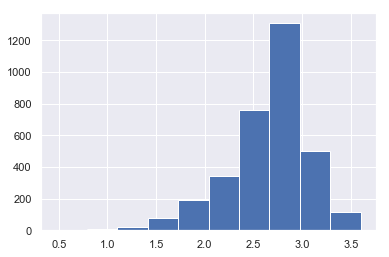

In [303]:
scp_clean['logTotalHours']= np.log10(scp_clean['TotalHours'])

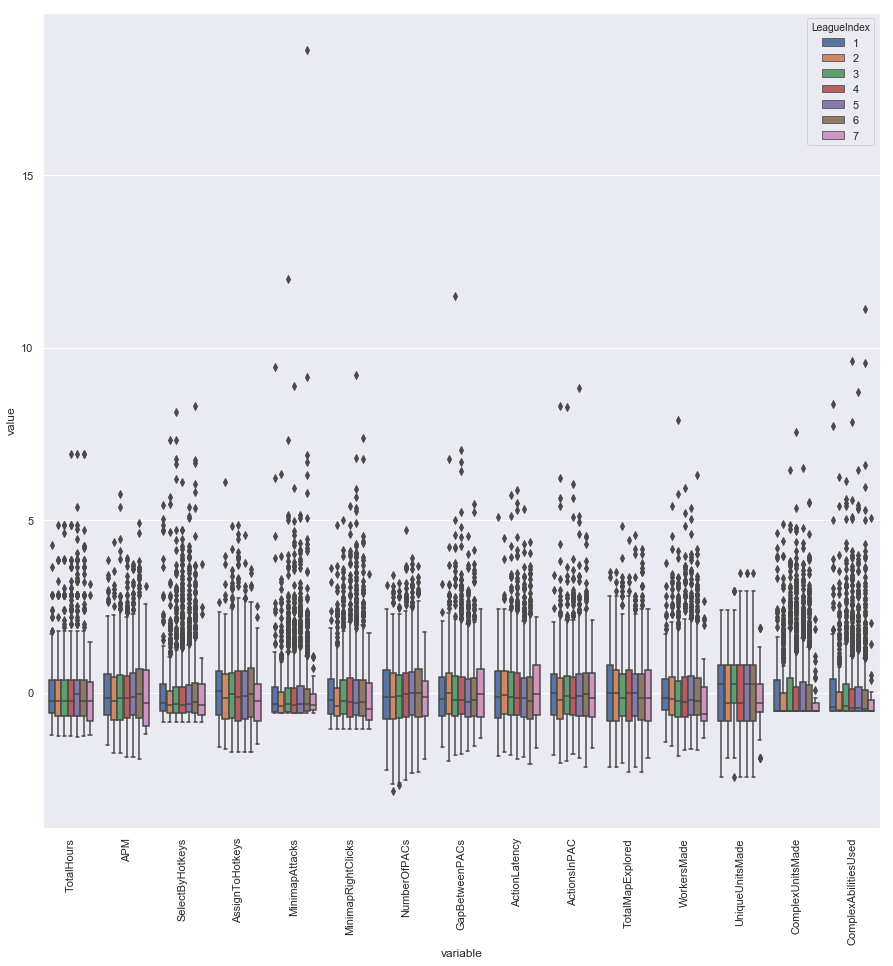

In [7]:
# Tutorial : https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization

features = ['TotalHours','APM','SelectByHotkeys','AssignToHotkeys','MinimapAttacks','MinimapRightClicks'
           ,'NumberOfPACs','GapBetweenPACs','ActionLatency','ActionsInPAC','TotalMapExplored','WorkersMade','UniqueUnitsMade'
           ,'ComplexUnitsMade','ComplexAbilitiesUsed']

x = scp_clean.loc[:, features].values
y = scp_clean.loc[:,['LeagueIndex']].values
x = StandardScaler().fit_transform(x)

scp_scaled = pd.DataFrame(data=x, columns = features)
scp_scaled['LeagueIndex'] = scp['LeagueIndex'] # Adding LeagueIndex columns to the pd dataframe

scp_scaled = pd.melt(scp_scaled,id_vars="LeagueIndex") # Creating the tidy dataframe

# Visualization 
plt.figure(figsize=(15,15))
sns.boxplot(x="variable", y="value", hue="LeagueIndex", data=scp_scaled)
plt.xticks(rotation=90)
plt.show()

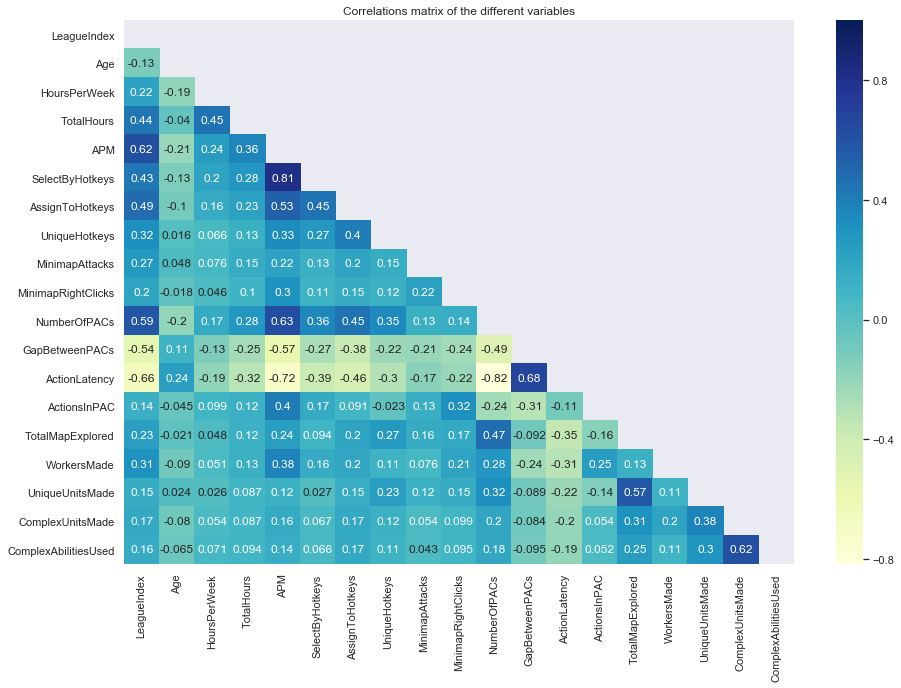

In [8]:
# Heatmap for the correlations of values / exploratory
dims = (15, 10) # Settings for the dimension of the heatmap
fig, ax = plt.subplots(figsize=dims)

# These two steps will hide the redondant correlations of the heatmap for readability
mask = np.zeros_like(scp_clean.corr()) # Returns zeros in the intial corr matrix
mask[np.triu_indices_from(mask)] = True # Returns the indices of the upper hand of the matrix and use it in the sns heat to hide them

with sns.axes_style("white"):
    sns.heatmap(scp_clean.corr(), annot=True,  mask=mask, ax=ax,cmap="YlGnBu")
plt.title('Correlations matrix of the different variables')
plt.show()

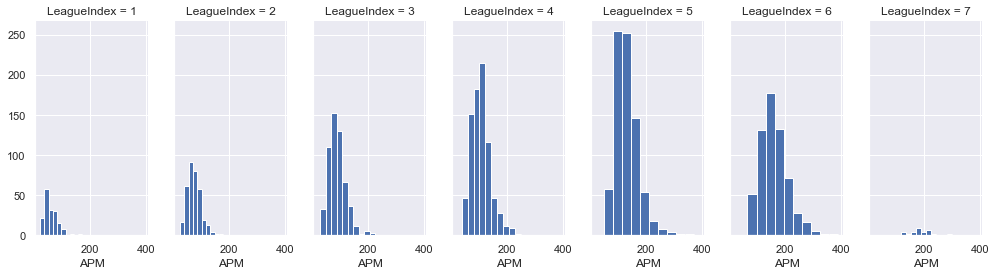

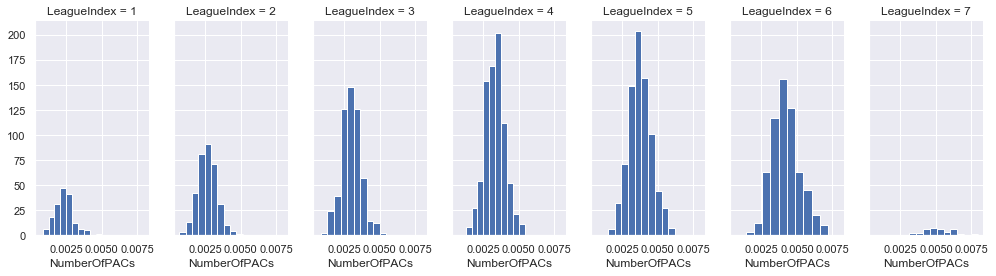

In [9]:
# Since League Index since well associated with APMs and NumberOfPACs of the players, let's look at the distribution of it as a function of
# League Index

a = sns.FacetGrid(scp_clean, col="LeagueIndex", height=4, aspect=.5)
a = a.map(plt.hist, "APM") # Histograms as a function of APM

b = sns.FacetGrid(scp_clean, col="LeagueIndex", height=4, aspect=.5)
b = b.map(plt.hist, "NumberOfPACs") # Histograms as a function of NumberOfPACs

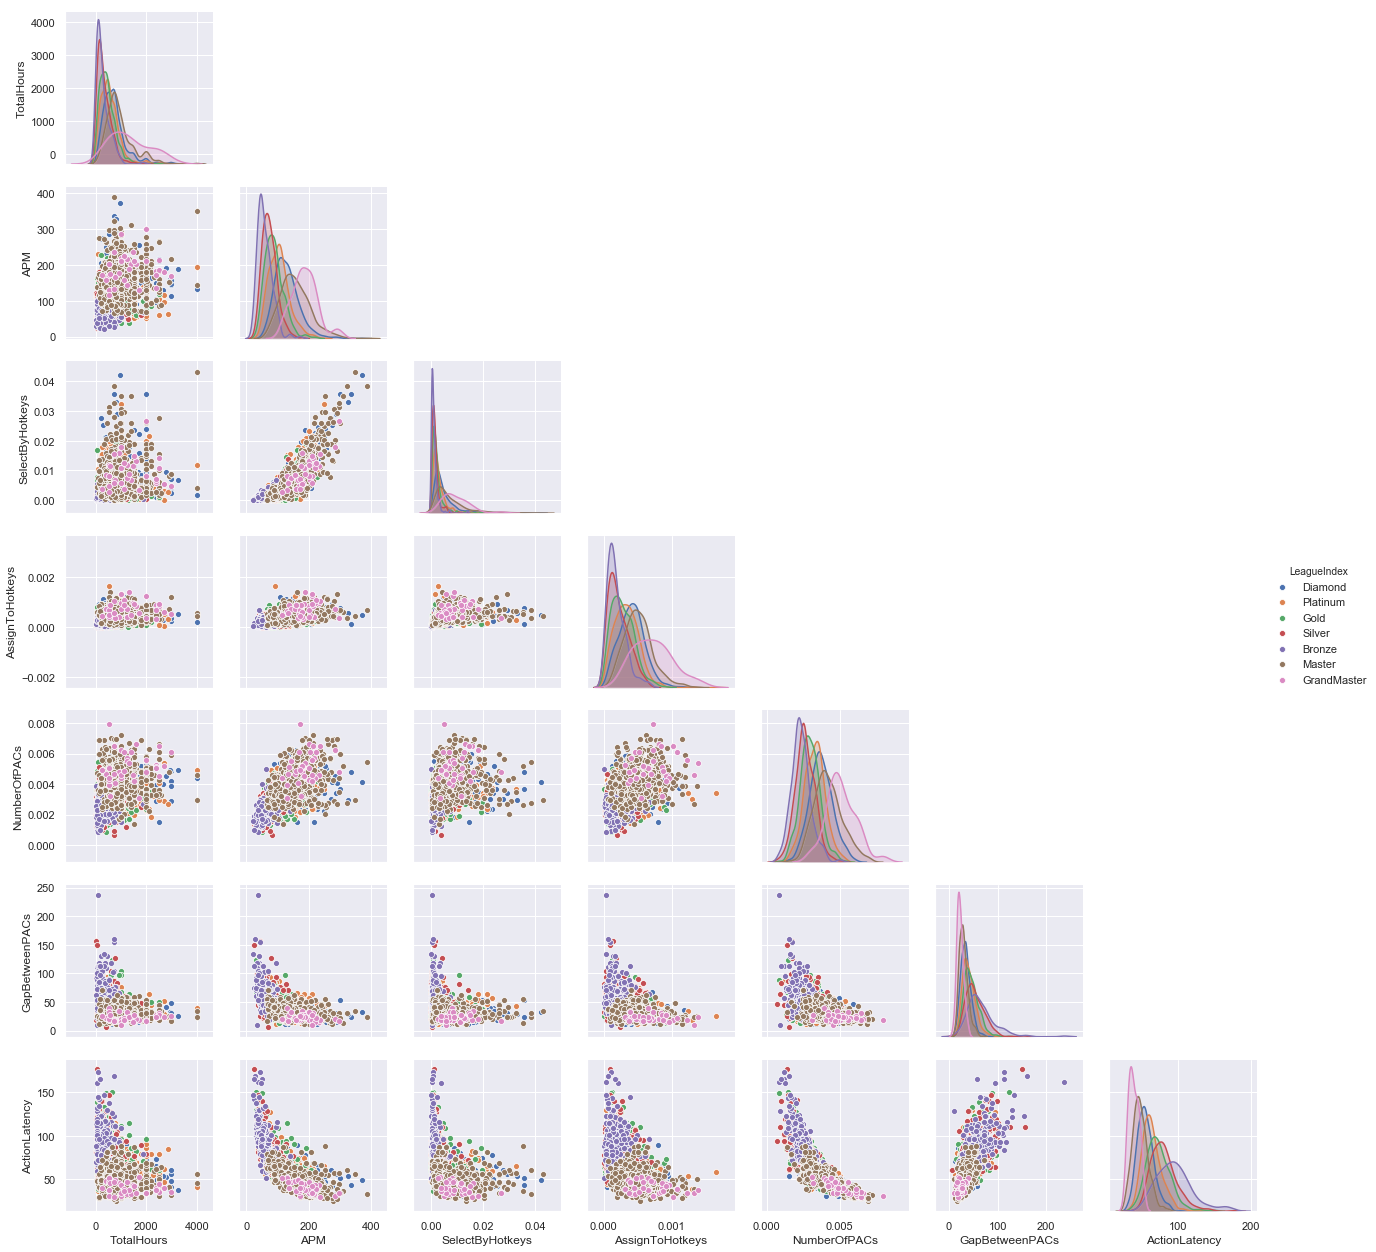

In [180]:
# Exploratoraty data analysis (EDA)
features = ['LeagueIndex','TotalHours','APM','SelectByHotkeys','AssignToHotkeys',
            'NumberOfPACs','GapBetweenPACs','ActionLatency']

scp_pairplot = scp_clean.loc[:, features]
b = sns.pairplot(scp_pairplot, hue="LeagueIndex", height=2.5)
for i, j in zip(*np.triu_indices_from(b.axes, 1)):
    b.axes[i, j].set_visible(False)

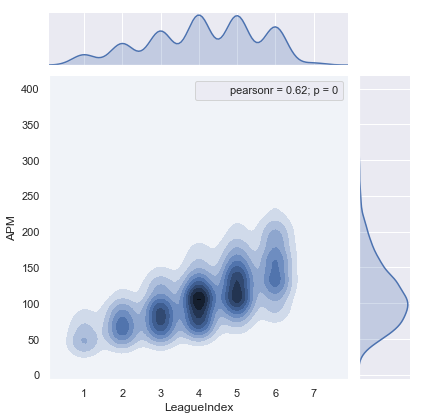

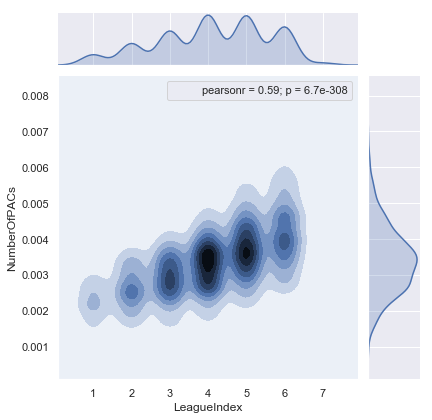

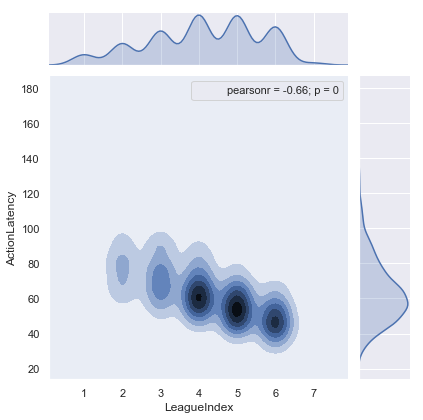

In [13]:
# Description text
plt1 = sns.jointplot(x='LeagueIndex', y='APM', data=scp_clean, kind="kde", color='b')
plt2 = sns.jointplot(x='LeagueIndex', y='NumberOfPACs', data=scp_clean, kind='kde', color='b')
plt3 = sns.jointplot(x='LeagueIndex', y='ActionLatency', data=scp_clean, kind='kde', color='b')
plt1.annotate(stats.pearsonr)
plt2.annotate(stats.pearsonr)
plt3.annotate(stats.pearsonr)

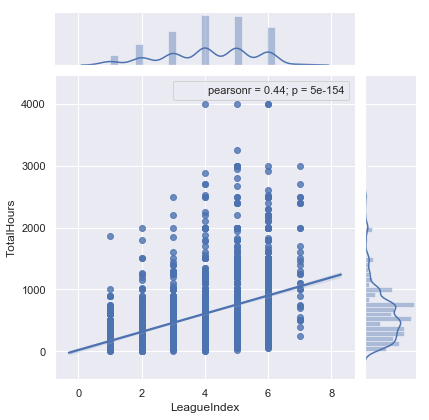

In [189]:
plt4 = sns.jointplot(x='LeagueIndex', y='TotalHours', data=scp_clean, kind="reg", color='b')
plt4.annotate(stats.pearsonr)

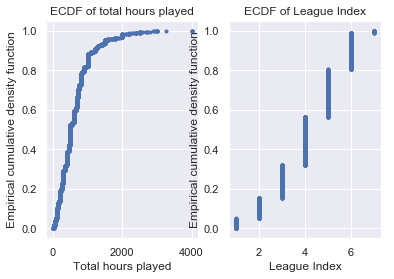

In [71]:
# Creation of an empirical cumulative density function
ecdf_hours = ECDF(scp_clean['TotalHours'])

plt.subplot(121)
_ = plt.plot(ecdf_hours.x, ecdf_hours.y, marker='.', linestyle='none')
_ = plt.xlabel('Total hours played')
_ = plt.ylabel('Empirical cumulative density function')
_ = plt.title('ECDF of total hours played')

ecdf_li = ECDF(scp_clean['LeagueIndex'])
plt.subplot(122)
_ = plt.plot(ecdf_li.x, ecdf_li.y, marker='.', linestyle='none')
_ = plt.xlabel('League Index')
_ = plt.ylabel('Empirical cumulative density function')
_ = plt.title('ECDF of League Index')


In [176]:
# Dimensionality reduction (pre-machine learning)
# https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb
features = ['TotalHours','APM','SelectByHotkeys','AssignToHotkeys','MinimapAttacks','MinimapRightClicks'
           ,'NumberOfPACs','GapBetweenPACs','ActionLatency','ActionsInPAC','TotalMapExplored','WorkersMade','UniqueUnitsMade'
           ,'ComplexUnitsMade','ComplexAbilitiesUsed']

x = scp_clean.loc[:, features].values
y = scp_clean.loc[:,['LeagueIndex']].values
x = StandardScaler().fit_transform(x)

scp_scaled = pd.DataFrame(data=x, columns = features)
scp_scaled['LeagueIndex'] = scp['LeagueIndex']

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data= principalComponents, columns = ['Principal Component 1', 'Principal Component 2'])

finalDf = pd.concat([principalDf, scp[['LeagueIndex']]], axis=1)
finalDf.head(5)

#pca.explained_variance_ratio_

,Principal Component 1,Principal Component 2,LeagueIndex
0,-2.252830,-0.616238,Diamond
1,1.350669,0.410418,Diamond
2,0.200829,0.354241,Platinum
3,0.109267,-2.793317,Gold
4,4.005226,0.791943,Gold


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


Model Performance
Average Error: 0.8394 degrees.
Accuracy = 74.06%.
Model Performance
Average Error: 0.7263 degrees.
Accuracy = 75.61%.
Improvement of 2.10%.


Text(89.18,0.5,'Predicted label')

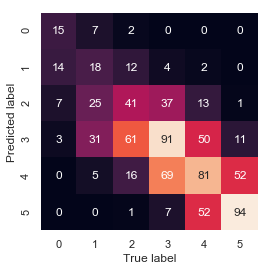

In [5]:
# Random Forest (RF) modeling
# Creation of the random forest classification tree for a supervised machine learning classification of player's skill rank

# https://scikit-learn.org/stable/modules/tree.html
# https://www.kdnuggets.com/2018/12/guide-decision-trees-machine-learning-data-science.html
# https://www.python-course.eu/Decision_Trees.php
# https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
# https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html **best**
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 *coding for parameter estimators*


# Training / Test sets creation
scp_clean_lowranks = scp_clean[scp_clean.LeagueIndex < 7] # Removing very high ranking players because of a very low amount
data = scp_clean_lowranks.iloc[:,1:]
labels = scp_clean_lowranks['LeagueIndex']

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25)

# ----------------------

# Pamameters search for optimization of the random forest model predictions

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf_rf = RandomForestClassifier(random_state = 42)   
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_rf_random = RandomizedSearchCV(estimator = clf_rf, param_distributions = random_grid, n_iter = 5, cv = 10, 
                                   verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
clf_rf_random.fit(X_train, y_train)

# Defining a function to evaluate models accuracy on test sets
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# Evaluating performance of a base model (without the random parameter search)
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

# Evaluating the best model found with the parameter estimators search
best_random = clf_rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

# Printing the improvement difference from those two models
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

# ------------------

# Prediction of the models for the confusion matrix
y_pred = best_random.predict(X_test) # Prediction of some observation from the test set for confusion matrix  

# Confusion matrix scores with SNS heatmap to visualize the accuracy of the modeling
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')

Text(0,0.5,'Features name')

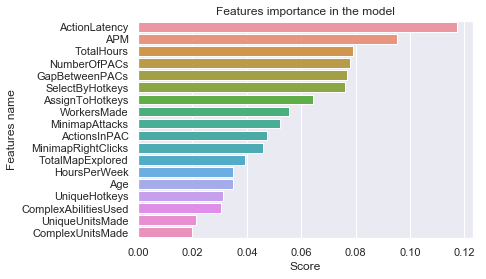

In [6]:
# Visualization of features importance

# https://scikit-learn.org/stable/modules/ensemble.html#forest Section : 1.11.2.5
# Basically, a feature importance can be measured at how well it splits the classification model. Features that appears 
# at the top of the tree generally have an higher importance since they split much more the classification then the others.
# The score of all the features together will sum to 1.

feature_imp = pd.Series(best_random.feature_importances_,index=data.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title("Features importance in the model")
plt.xlabel("Score")
plt.ylabel("Features name")

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   53.0s finished


Model Performance
Average Error: 0.8236 degrees.
Accuracy = 74.28%.
Model Performance
Average Error: 0.7348 degrees.
Accuracy = 76.23%.
Improvement of 2.63%.


Text(89.18,0.5,'Predicted label')

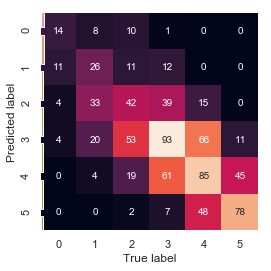

In [50]:
# -------------- Feature selection with RF model --------------

# Modeling with feature selection (https://www.datacamp.com/community/tutorials/random-forests-classifier-python)

# Visualization of features importance 
feature_imp = pd.Series(best_random.feature_importances_,index=data.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

# Since quite a lot of features have an importance score below 0.4, we will remove these features from the model.
# This will create a better model for two reasons ; (1) reduce the noise, (2) faster computing time
scp_clean_lowranks = scp_clean[scp_clean.LeagueIndex < 7] # Removing very high ranking players because of a very low amount
features_selection = ['ActionLatency', 'APM', 'NumberOfPACs', 'SelectByHotkeys', 'TotalHours', 'GapBetweenPACs',
                     'AssignToHotkeys', 'MinimapAttacks', 'WorkersMade', 'ActionsInPAC', 'MinimapRightClicks']
data = scp_clean_lowranks.loc[:,features_selection]
labels = scp_clean_lowranks['LeagueIndex']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data, labels, test_size=0.25)

# ------------------

# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf_rf = RandomForestClassifier(random_state = 42)   
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_rf_random = RandomizedSearchCV(estimator = clf_rf, param_distributions = random_grid, n_iter = 5, cv = 10, 
                                   verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
clf_rf_random.fit(X_train_f, y_train_f)
# Evaluating performance of a base model (without the random parameter search)
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train_f, y_train_f)
base_accuracy = evaluate(base_model, X_test_f, y_test_f)

# Evaluating the best model found with the parameter estimators search
best_random_2 = clf_rf_random.best_estimator_
random_accuracy = evaluate(best_random_2, X_test_f, y_test_f)

# Printing the improvement difference from those two models
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

# ------------------

# Prediction of the models for the confusion matrix
y_pred_f = best_random_2.predict(X_test_f) # Prediction of some observation from the test set for confusion matrix  

# Confusion matrix scores with SNS heatmap to visualize the accuracy of the modeling
mat = confusion_matrix(y_test_f, y_pred_f)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')

             precision    recall  f1-score   support

          1       0.18      0.27      0.22        26
          2       0.26      0.26      0.26        72
          3       0.33      0.03      0.05       115
          4       0.21      0.03      0.05       150
          5       0.17      0.09      0.12       175
          6       0.27      0.94      0.41       120

avg / total       0.24      0.25      0.16       658



Text(89.18,0.5,'predicted label')

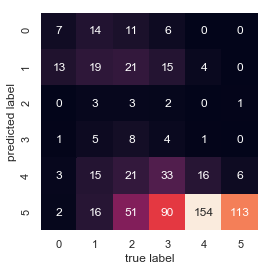

In [25]:
# Support Vector Machine (SVM) modeling

from sklearn import svm

# Training / Test sets creation
scp_clean_lowranks = scp_clean[scp_clean.LeagueIndex < 7] # Removing very high ranking players because of a very low amount
data = scp_clean_lowranks.iloc[:,1:]
labels = scp_clean_lowranks['LeagueIndex']

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20)

lin_clf = svm.LinearSVC()
lin_clf.fit(X_train, y_train) 

y_pred = lin_clf.predict(X_test) # Prediction of some observation from the test set for confusion matrix  
print(classification_report(y_test, y_pred)) 

# Confusion matrix scores with SNS heatmap to visualize the accuracy of the modeling
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
# Deep Neural Decision Tree (Neural Network based + PyTorch / TensorFlow)

# https://github.com/wOOL/DNDT/blob/master/tensorflow/demo.ipynb
# https://arxiv.org/pdf/1806.06988.pdf

In [38]:
#Changing League Index information
scp_clean['LeagueIndex'] = scp_clean['LeagueIndex'].astype('category') # Switching the variable type from integers to category for 
                                                           # League Index

# Association of the intergers number to the respective League Index
scp_clean['LeagueIndex'] = scp_clean['LeagueIndex'].map({1:'Bronze', 2:'Silver', 3:'Gold', 4:'Platinum', 5:'Diamond', 
                                        6:'Master', 7:'GrandMaster', 8:'Professional'})
scp_clean.head(5)

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,Diamond,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
2,Platinum,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,Gold,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,Gold,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019
5,Silver,27,6,70,44.4570,0.000978,0.000255,2,0.000000,0.000000,0.002425,76.4405,98.7719,3.0965,16,0.000372,6,0.0,0.000000
